In [54]:
import seaborn as sns
import pandas as pd
from os import path
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             roc_curve, precision_recall_curve, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from scipy import stats

In [44]:
def bxplot(x,name):
    plt.boxplot(x)
    plt.title(f"{name}")
    plt.show()

def plot_regression_diagnostics(model_name, y_test, y_pred, X_train=None, model=None, top_n=15):
    # Метрики
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    plt.figure(figsize=(18, 12))

    # 1. Фактические vs Предсказанные
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
             color='red', linestyle='--', linewidth=2)
    plt.title(f'Фактические vs Предсказанные значения\n{model_name}', fontsize=14)
    plt.xlabel('Фактические значения (y_test)', fontsize=12)
    plt.ylabel('Предсказанные значения (y_pred)', fontsize=12)
    textstr = '\n'.join((
        f'MSE: {mse:.4f}',
        f'RMSE: {rmse:.4f}',
        f'MAE: {mae:.4f}',
        f'R²: {r2:.4f}'))
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 2. Распределение остатков
    residuals = y_test - y_pred
    plt.subplot(2, 2, 2)
    sns.histplot(residuals, kde=True, bins=30, color='green')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
    plt.title('Распределение остатков', fontsize=14)
    plt.xlabel('Остатки (y_test - y_pred)', fontsize=12)
    plt.ylabel('Частота', fontsize=12)

    # 3. Остатки vs Предсказанные
    plt.subplot(2, 2, 3)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color='orange')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
    plt.title('Остатки vs Предсказанные значения', fontsize=14)
    plt.xlabel('Предсказанные значения (y_pred)', fontsize=12)
    plt.ylabel('Остатки', fontsize=12)

    # 4. Q-Q plot
    plt.subplot(2, 2, 4)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q plot остатков', fontsize=14)
    plt.xlabel('Теоретические квантили', fontsize=12)
    plt.ylabel('Выборочные квантили', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Визуализация важности признаков
    if X_train is not None and model is not None:
        if hasattr(model, 'coef_'):
            importances = model.coef_
        elif hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            importances = None

        if importances is not None:
            feature_importance = pd.DataFrame({
                'Feature': X_train.columns,
                'Importance': importances
            }).sort_values(by='Importance', key=abs, ascending=False)

            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n), palette='viridis')
            plt.title(f'Топ-{top_n} значимых признаков\n{model_name}', fontsize=14)
            plt.xlabel('Важность признака', fontsize=12)
            plt.ylabel('Признак', fontsize=12)
            plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
            plt.tight_layout()
            plt.show()


In [17]:
df = pd.read_csv(path.join("data_practice.csv"))
df

,smiles,A,B,C,mu,alpha,homo,lumo,gap,r2,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,N#CC12CC1CO2,5.99438,2.27301,1.94738,4.5933,55.81,-0.2627,-0.0086,0.2541,650.3290,...,0,0,0,0,0,0,0,0,0,0
1,COCC(O)C#CC=O,2.32923,0.75737,0.59946,3.4068,77.34,-0.2697,-0.0657,0.2040,1808.5114,...,0,0,0,0,0,0,0,0,0,0
2,COC1C2CC(=NO)C12,2.71950,1.23126,1.02616,1.2920,76.75,-0.2258,0.0156,0.2414,1215.4323,...,0,0,0,0,0,0,0,0,0,0
3,CC(CC=O)OCC#C,2.29944,0.85305,0.65285,3.1488,79.50,-0.2438,-0.0199,0.2239,1685.1071,...,0,0,0,1,0,0,0,0,0,0
4,COC(=N)N1CCC1=N,3.03493,1.26316,0.90731,1.9135,77.81,-0.2343,0.0056,0.2400,1271.6972,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,C1CC1(CCC#N)C=O,2.81953,0.95253,0.78315,5.6157,77.77,-0.2667,-0.0340,0.2328,1442.5369,...,0,0,0,0,0,0,0,0,0,0
4996,CCN1C2CC3OC2C13,4.22393,1.23139,1.15079,1.2093,78.14,-0.2139,0.0760,0.2898,1141.0494,...,0,0,0,0,0,0,0,0,0,0
4997,CN1C2CC(O)CC12C,2.40023,1.44261,1.26824,2.0425,81.95,-0.2130,0.0709,0.2839,1145.1258,...,0,0,0,0,0,0,0,0,0,0
4998,c1cnc([nH]1)OC=O,8.05652,1.25277,1.08801,4.1565,58.08,-0.2300,-0.0153,0.2147,988.9973,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df = df.drop_duplicates()
missing_values = df.isnull().sum().sort_values(ascending=False)

for column_name in df.columns[2:len(df.columns)]:
    #Обнаруживаем выбросы
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    # Удаление выбросов из основного DataFrame
    df2 = df[(df[column_name] >= Q1 - 1.5 * IQR) & (df[column_name] <= Q3 + 1.5 * IQR)]
df = df2

#дисперсия
# Отделяем первый столбец, который не будем использовать для отбора
first_column = df.iloc[:,0: 1]
gap = df['gap']
df.drop(['gap'],axis=1, inplace=True)
df.drop(first_column,axis=1, inplace=True)

disp = df.var()

FILTER_THRESHOLD = 0.1
to_drop = [column for column in disp.index if disp[column] < FILTER_THRESHOLD]
df = df.drop(to_drop, axis=1)

# Соединяем первый столбец с отобранными признаками
df = pd.concat([first_column, gap, df], axis=1)
df

,smiles,gap,A,B,C,mu,alpha,r2,u0,u298,...,fr_aryl_methyl,fr_bicyclic,fr_epoxide,fr_ether,fr_ketone,fr_ketone_Topliss,fr_methoxy,fr_nitrile,fr_piperdine,fr_term_acetylene
0,N#CC12CC1CO2,0.2541,5.99438,2.27301,1.94738,4.5933,55.81,650.3290,-323.338627,-323.332830,...,0,1,0,1,0,0,0,1,0,0
1,COCC(O)C#CC=O,0.2040,2.32923,0.75737,0.59946,3.4068,77.34,1808.5114,-458.914682,-458.903948,...,0,0,0,1,0,0,1,0,0,0
2,COC1C2CC(=NO)C12,0.2414,2.71950,1.23126,1.02616,1.2920,76.75,1215.4323,-438.996978,-438.988148,...,0,1,0,1,0,0,1,0,0,0
3,CC(CC=O)OCC#C,0.2239,2.29944,0.85305,0.65285,3.1488,79.50,1685.1071,-422.988608,-422.977883,...,0,0,0,1,0,0,0,0,0,1
4,COC(=N)N1CCC1=N,0.2400,3.03493,1.26316,0.90731,1.9135,77.81,1271.6972,-435.272093,-435.262958,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,C1CC1(CCC#N)C=O,0.2328,2.81953,0.95253,0.78315,5.6157,77.77,1442.5369,-401.969669,-401.960439,...,0,0,0,0,0,0,0,1,0,0
4996,CCN1C2CC3OC2C13,0.2898,4.22393,1.23139,1.15079,1.2093,78.14,1141.0494,-403.082393,-403.074974,...,0,0,0,1,0,0,0,0,0,0
4997,CN1C2CC(O)CC12C,0.2839,2.40023,1.44261,1.26824,2.0425,81.95,1145.1258,-404.332161,-404.322884,...,0,1,0,0,0,0,0,0,1,0
4998,c1cnc([nH]1)OC=O,0.2147,8.05652,1.25277,1.08801,4.1565,58.08,988.9973,-414.713710,-414.706937,...,0,0,0,1,0,0,0,0,0,0


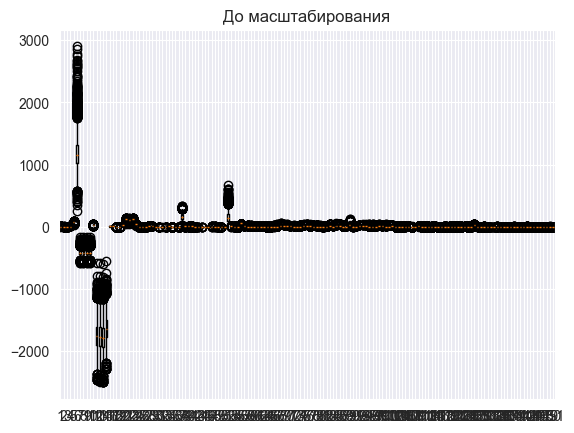

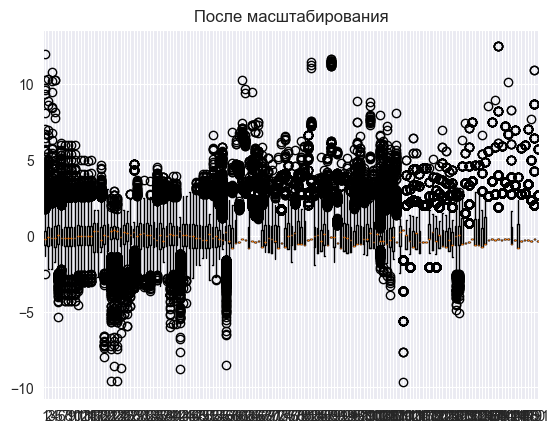

In [27]:
X = df.drop(columns=['smiles', 'gap']) #все остальное
y = df['gap']  # Целевая переменная

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

bxplot(X_train,"До масштабирования")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

bxplot(X_train_scaled,"После масштабирования")


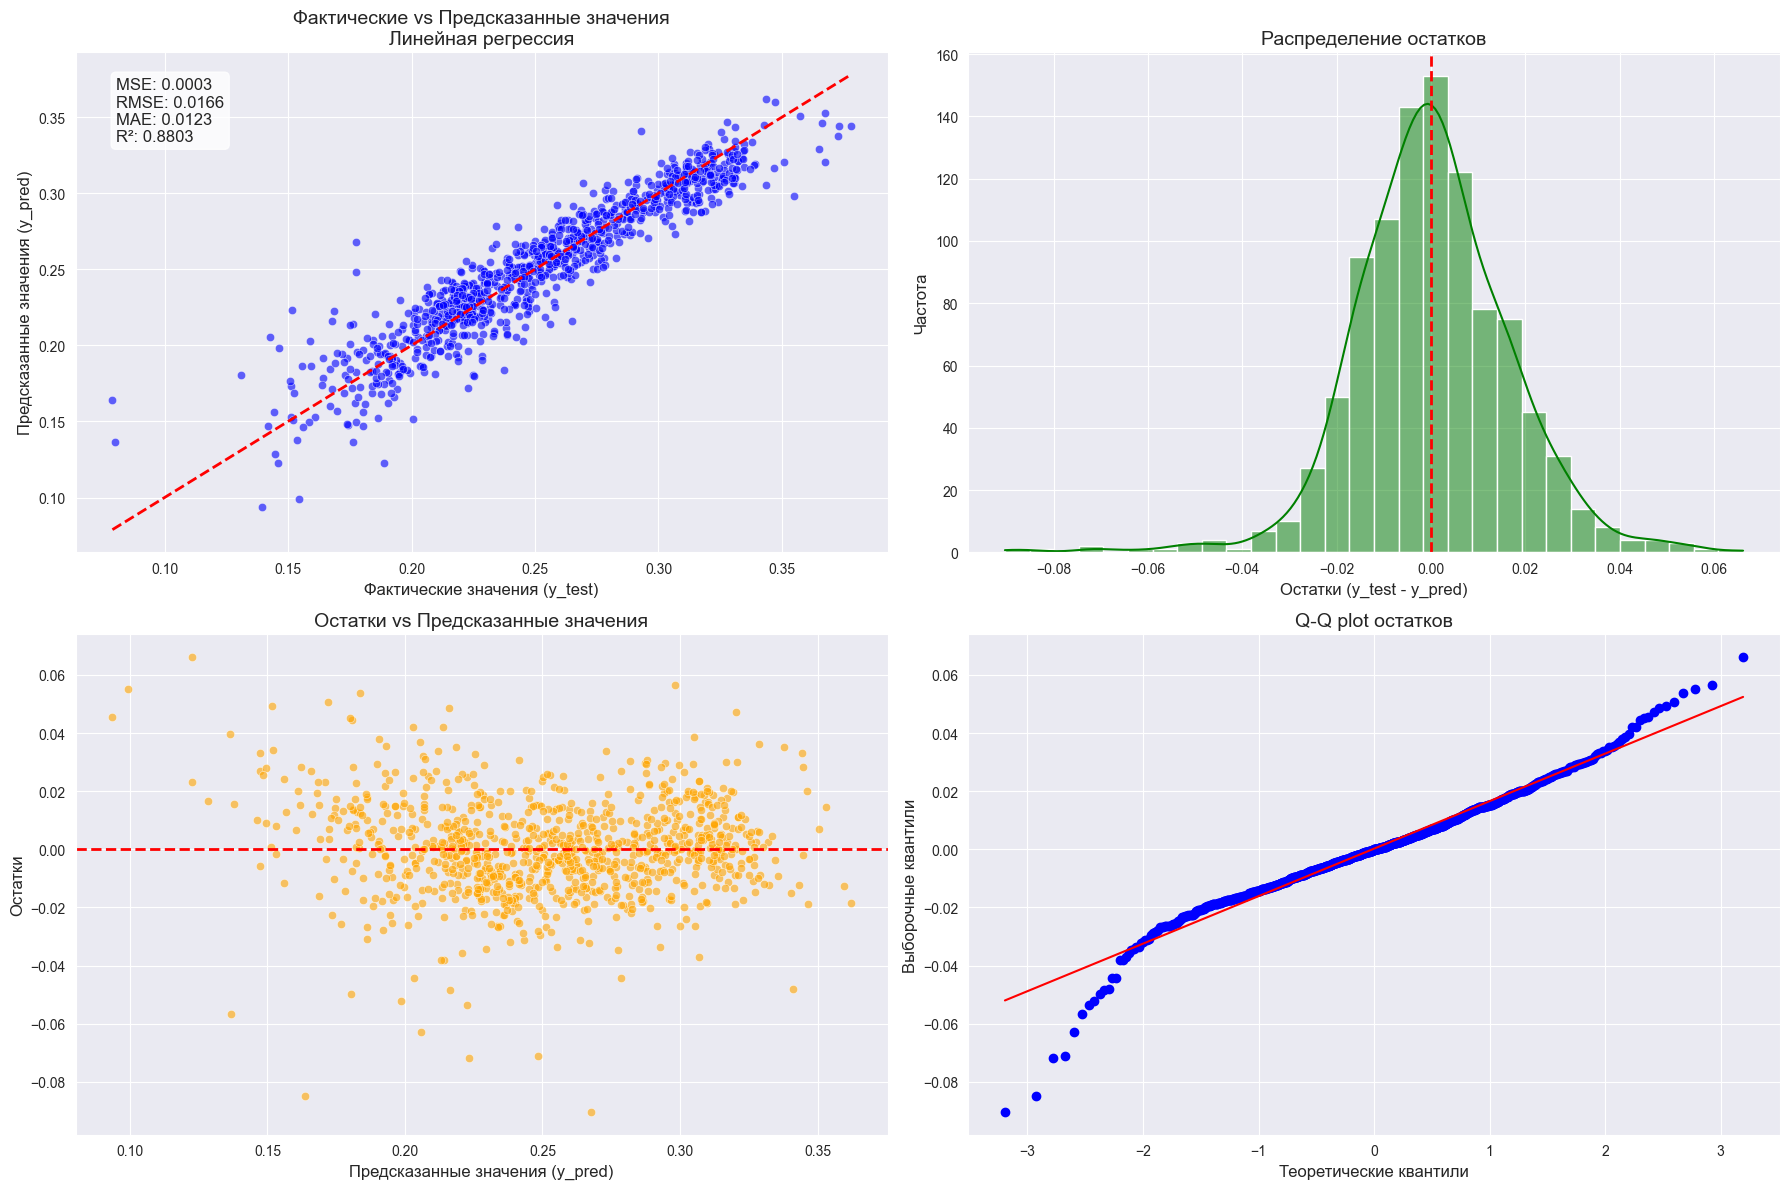

/var/folders/ss/kpmpr51x6bqc4fmwrx3vq3s00000gn/T/ipykernel_28964/1426723880.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n), palette='viridis')


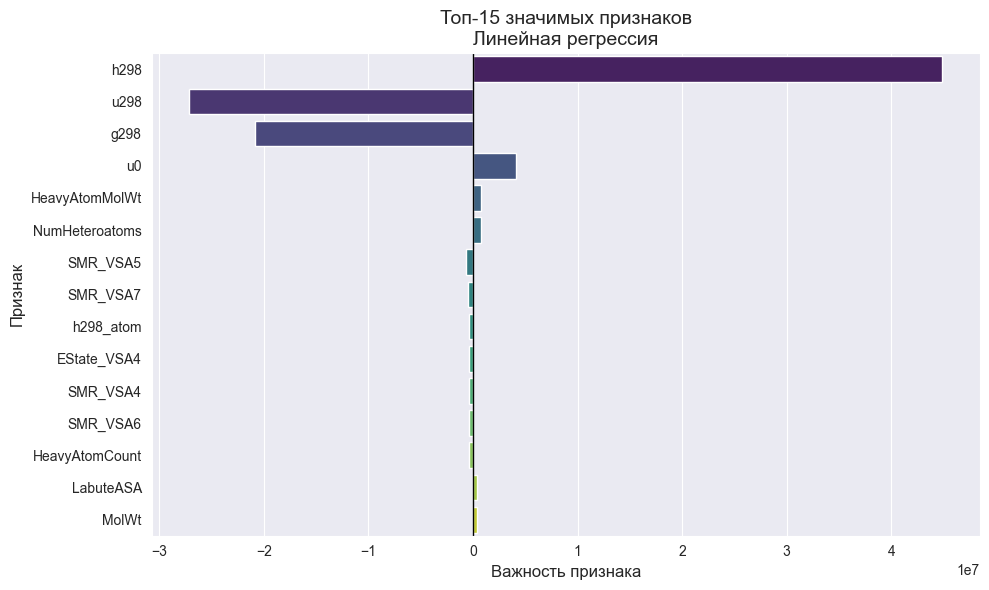

In [45]:
#Линейная регрессия
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Метрики
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

plot_regression_diagnostics(
    model_name='Линейная регрессия',
    y_test=y_test,
    y_pred=y_pred_lr,
    X_train=X_train,
    model=lr)

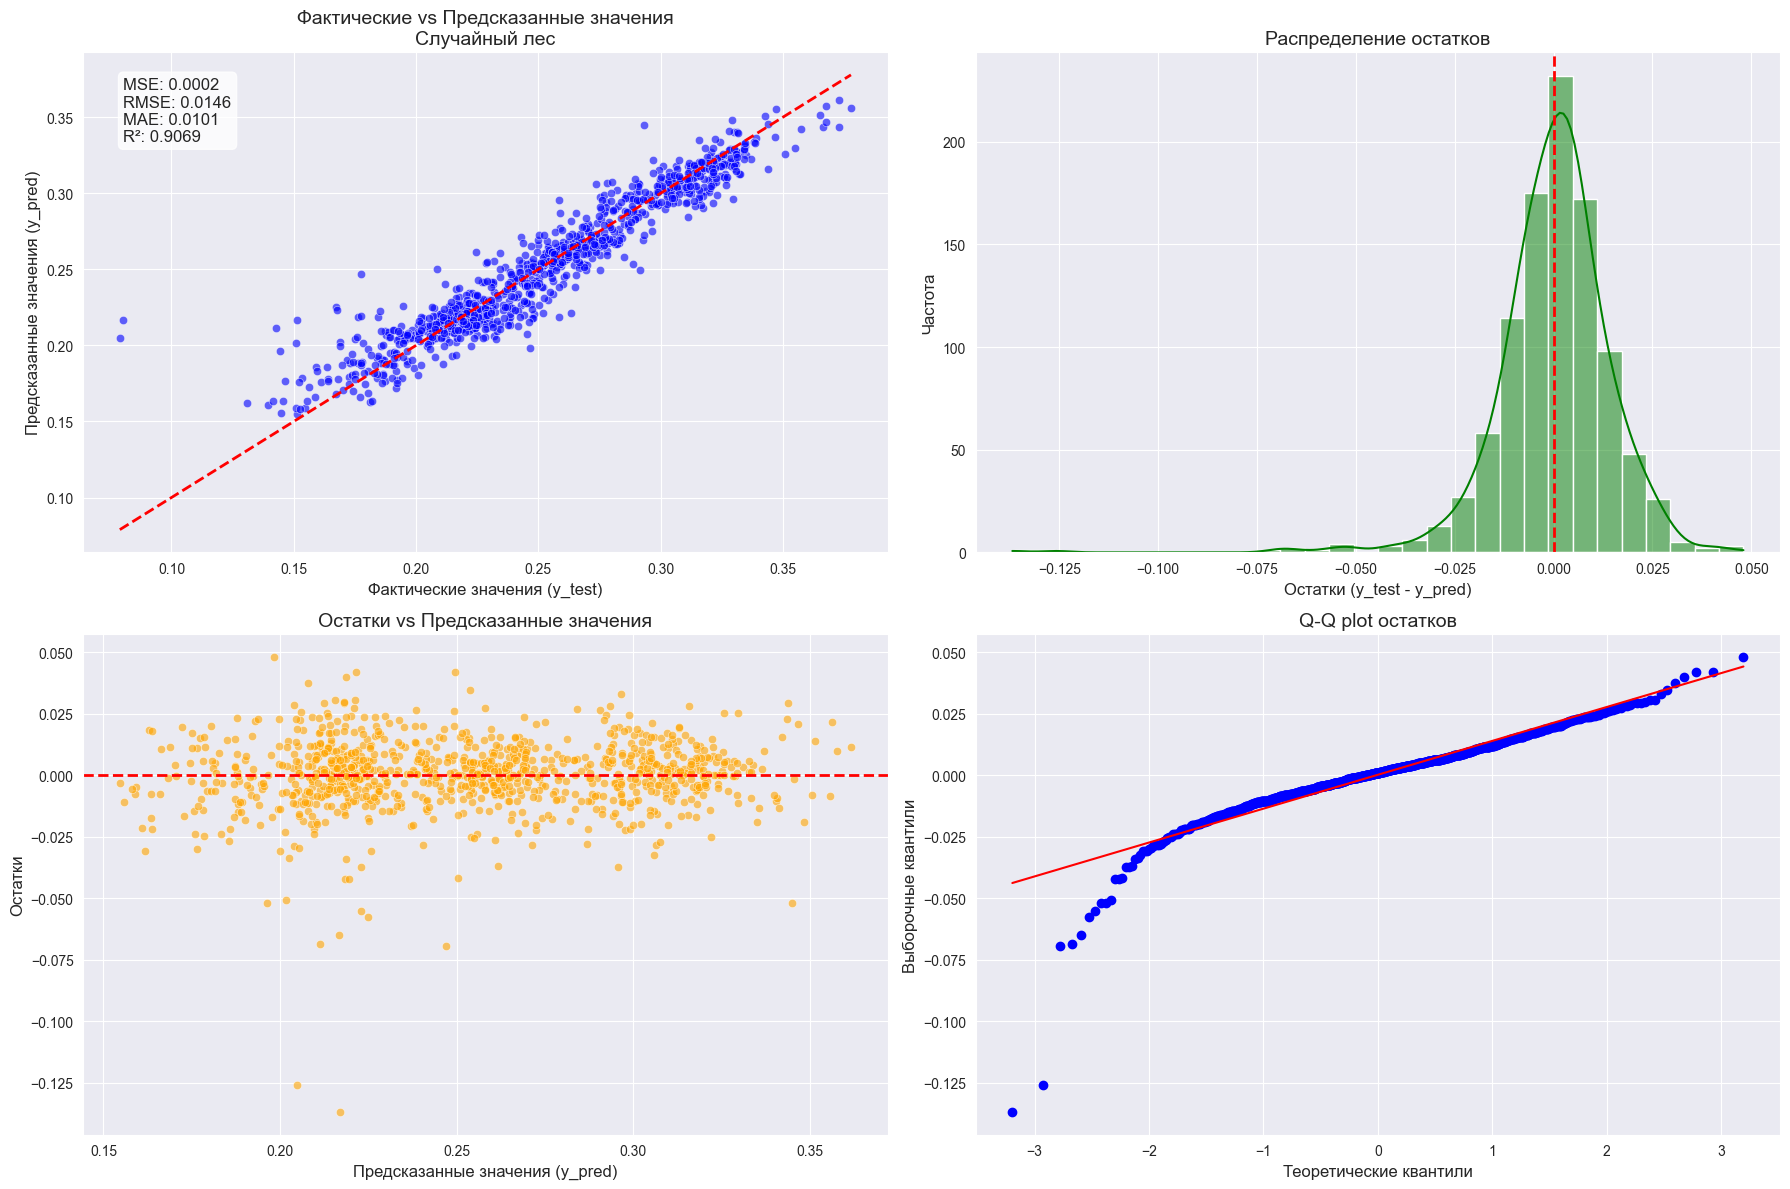

/var/folders/ss/kpmpr51x6bqc4fmwrx3vq3s00000gn/T/ipykernel_28964/1426723880.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n), palette='viridis')


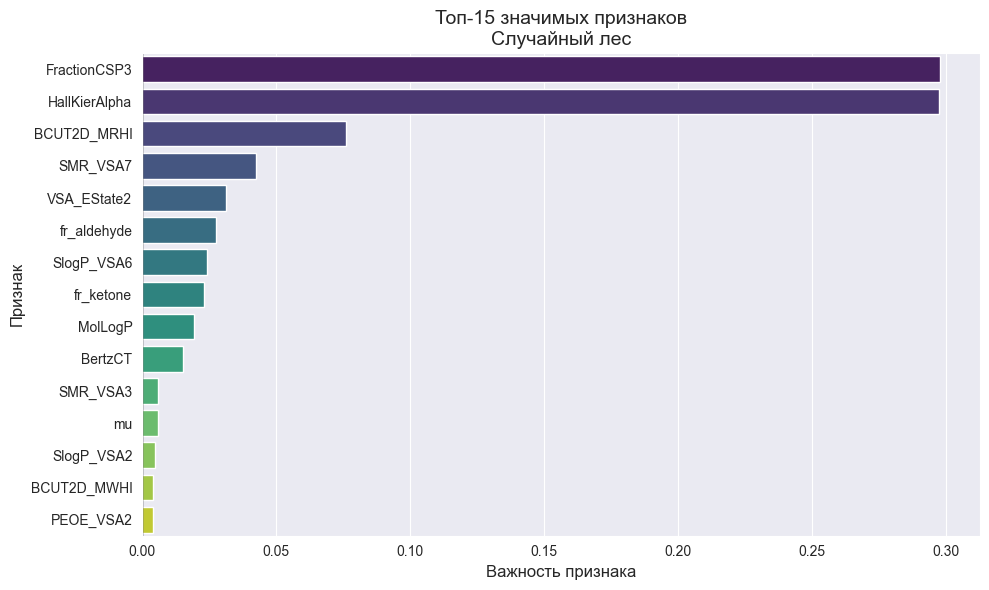

In [46]:
# Лес
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)  # RF не требует масштабирования
y_pred_rf = rf.predict(X_test)

# Метрики
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)


plot_regression_diagnostics(
    model_name='Случайный лес',
    y_test=y_test,
    y_pred=y_pred_rf,
    X_train=X_train,
    model=rf)

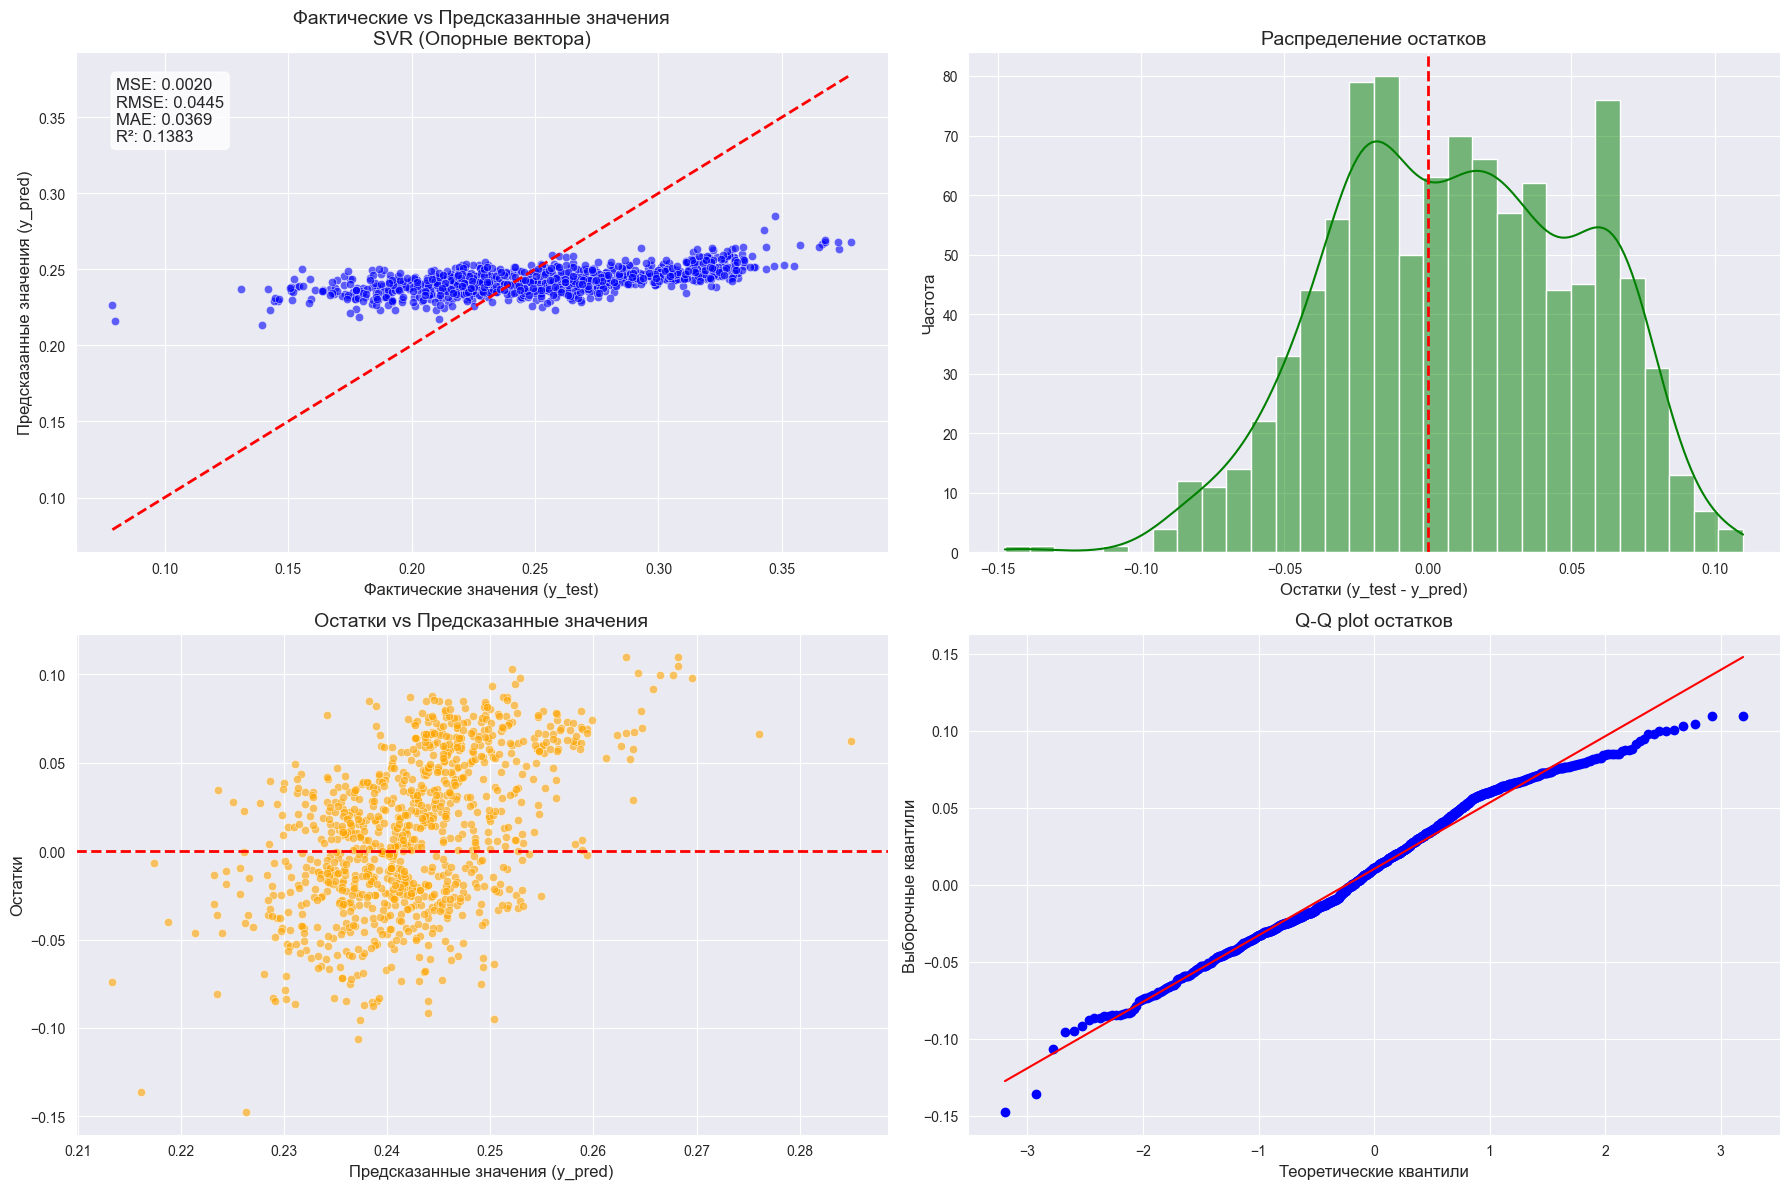

In [47]:
# Опорные вектора
svr = SVR()
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)

# Метрики
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

plot_regression_diagnostics(
    model_name='SVR (Опорные вектора)',
    y_test=y_test,
    y_pred=y_pred_svr)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


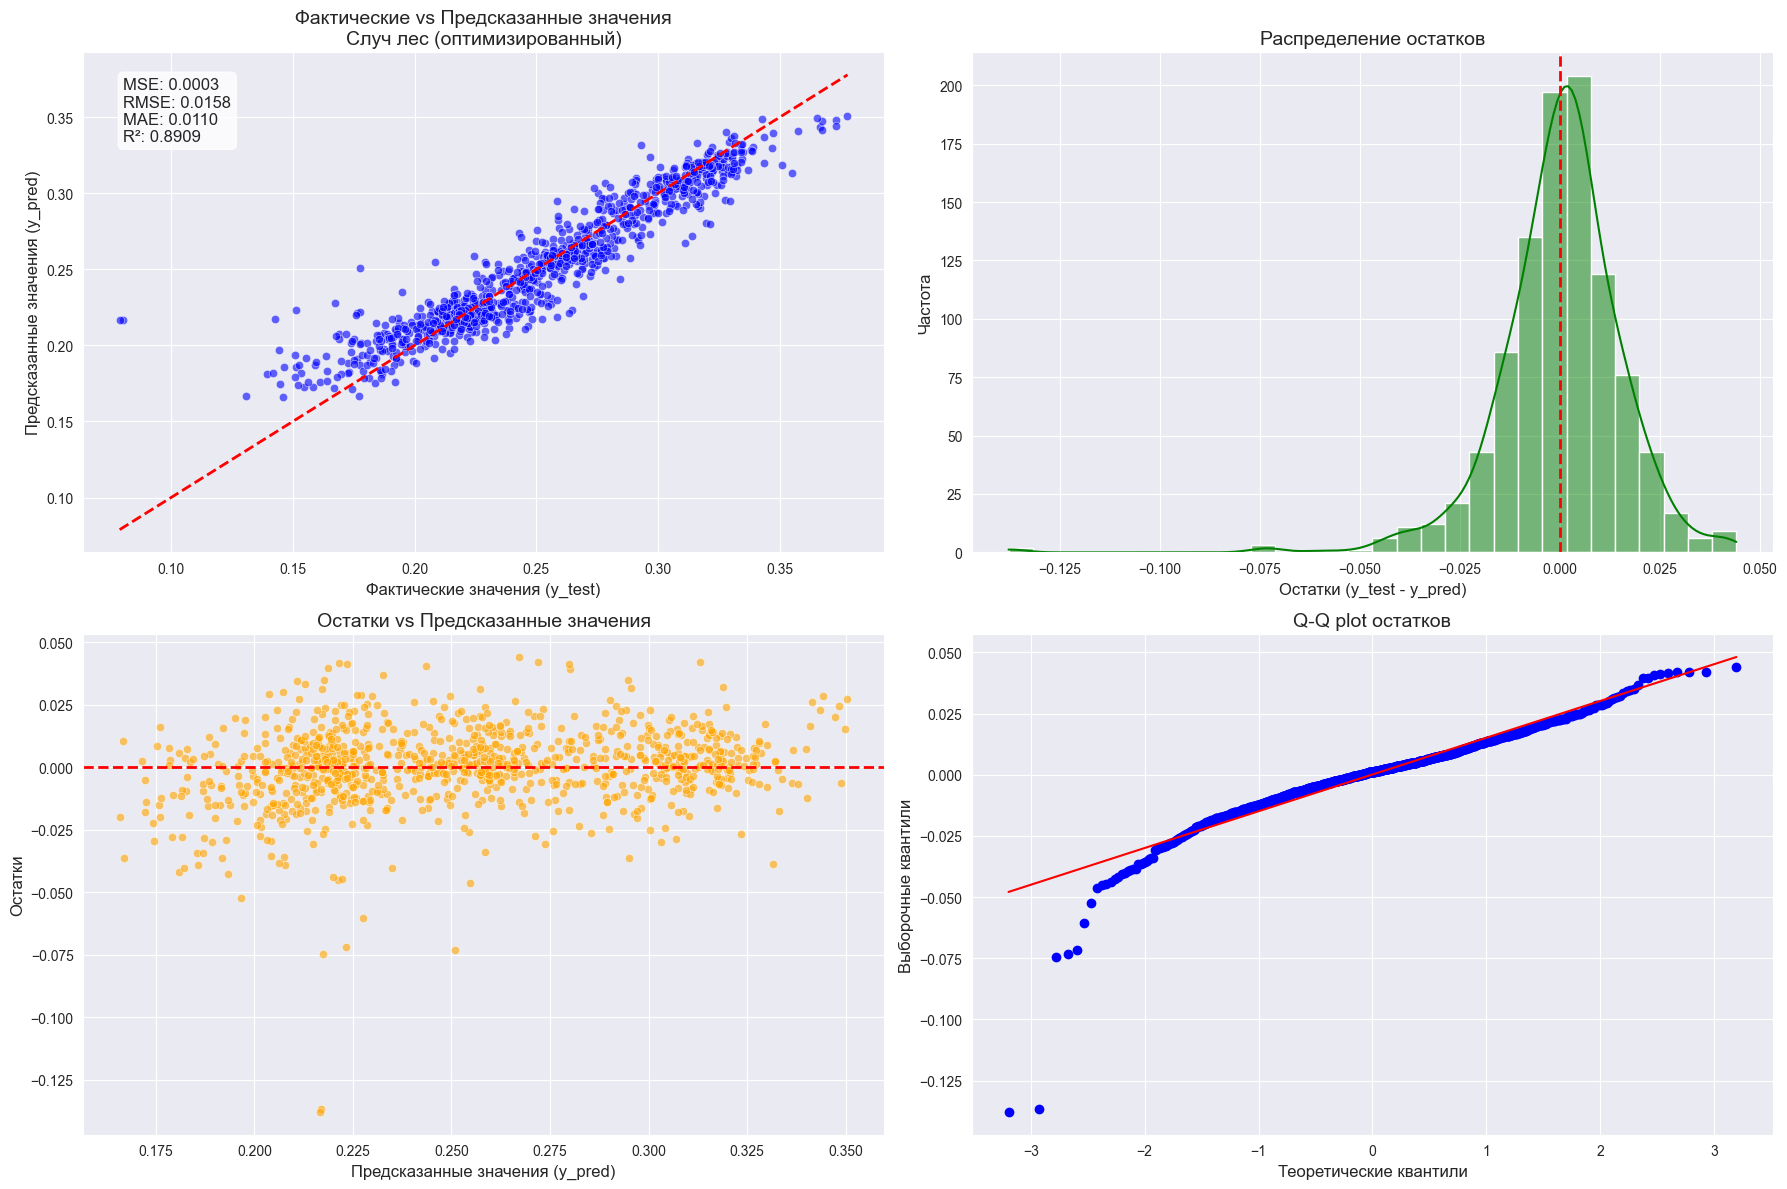

/var/folders/ss/kpmpr51x6bqc4fmwrx3vq3s00000gn/T/ipykernel_28964/1426723880.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n), palette='viridis')


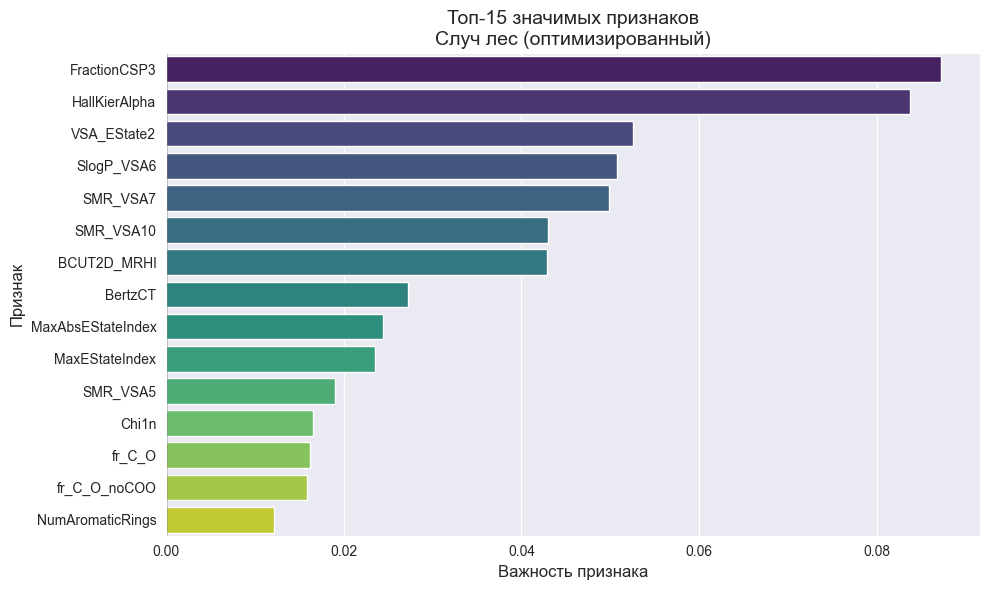

In [52]:
#Оптимизация леса, так как у линейной нет гиперпараметров, хотя линейная получше
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_


y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)


# Визуализация
plot_regression_diagnostics("Случ лес (оптимизированный)", y_test, y_pred_rf, X_train=X_train, model=best_rf)

/Users/kuki/PycharmProjects/machine-learning-TrippyBubble/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.93      0.95      0.94       732
           1       0.95      0.94      0.94       756

    accuracy                           0.94      1488
   macro avg       0.94      0.94      0.94      1488
weighted avg       0.94      0.94      0.94      1488

ROC-AUC: 0.9852


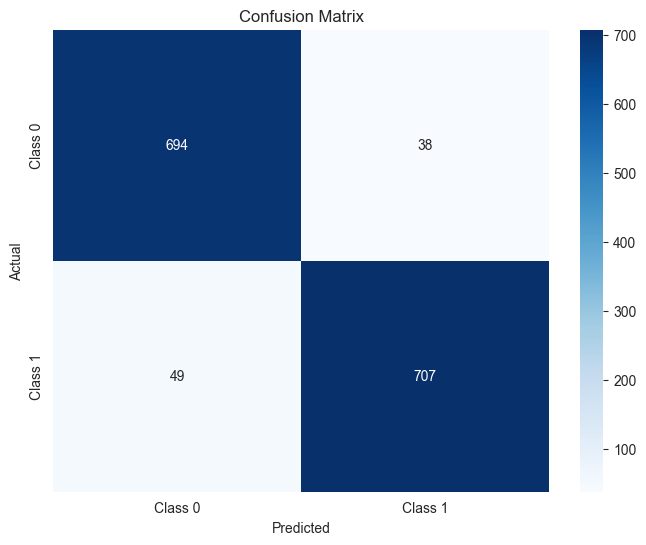

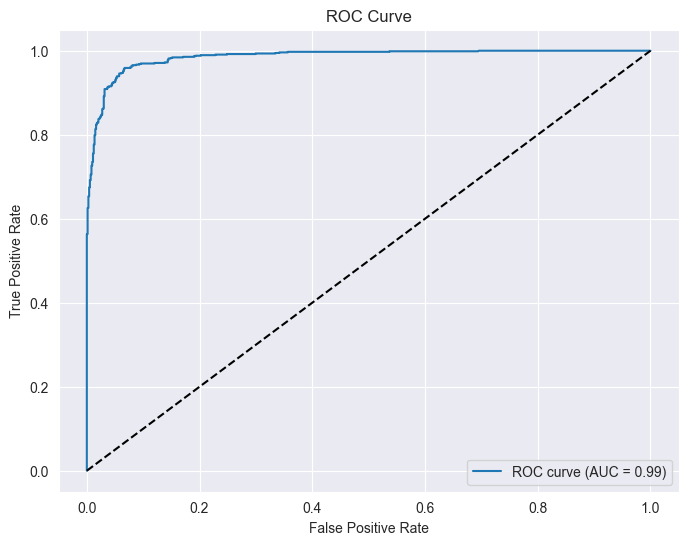

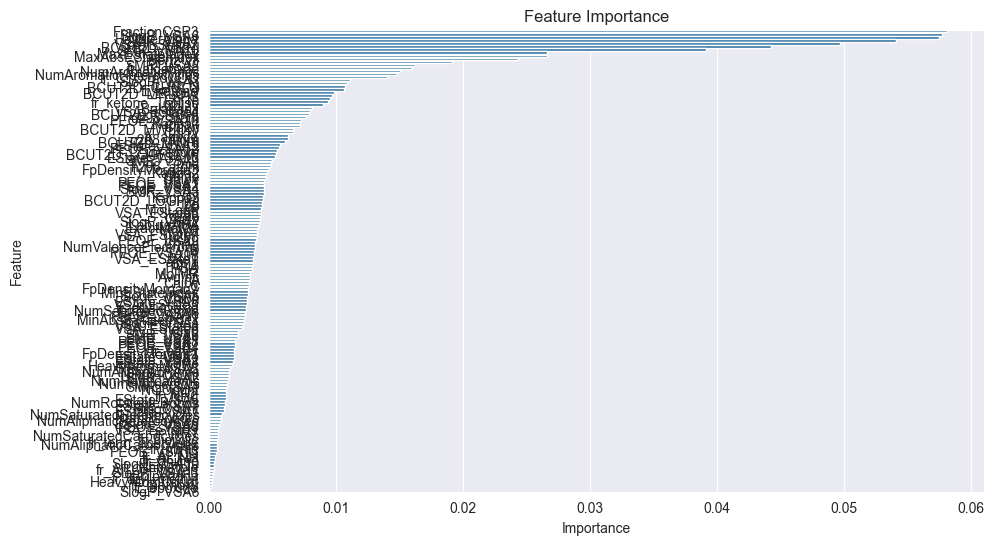

In [56]:
df = df.drop(columns=['smiles'])
median_gap = df['gap'].median()
df['Class'] = np.where(df['gap'] > median_gap, 1, 0)

# Разделение на признаки и целевую переменную
X = df.drop(['gap', 'Class'], axis=1) 
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Обучение и оценка 3 различных моделей
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True)}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Расчет метрик
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    }

# Вывод результатов
pd.DataFrame(results).T

# 3. Оптимизация гиперпараметров лучшей модели
# Предположим, Random Forest показал лучшие результаты
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_

# 4. Оценка оптимизированной модели
y_pred_best = best_rf.predict(X_test_scaled)
y_proba_best = best_rf.predict_proba(X_test_scaled)[:, 1]

# Метрики качества
print(classification_report(y_test, y_pred_best))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_best):.4f}")

# 5. Визуализация результатов
# Матрица ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_best), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_proba_best):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 6. Анализ важности признаков (для Random Forest)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()